In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

In [22]:
data1 = pd.read_csv('../results/benchmark/z_scores/gdsc/single/REACTOME_filtered_abs.csv',
                  sep=',', header=0, index_col=0)
data2 = pd.read_csv('../results/benchmark/z_scores/gdsc/single/BEST_dorothea_AB_filtered_abs.csv',
                   sep=',', header=0, index_col=0)

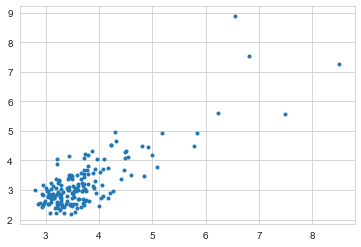

In [23]:
plt.plot(data1.abs().max(), data2.abs().max(), '.')

In [25]:
data2.abs().mean().sort_values()

SOS1_mut     0.626423
STAG2_mut    0.640042
CLSPN_mut    0.642659
LPHN2_mut    0.675770
ATM_mut      0.676575
               ...   
APC_mut      1.867573
BRAF_mut     1.901511
NRAS_mut     1.973234
KRAS_mut     2.051222
RB1_mut      2.306281
Length: 172, dtype: float64

In [28]:
data2['APC_mut'].sort_values()

RFX5     -4.125378
ETS2     -4.064519
RFXANK   -3.558985
RFXAP    -3.558985
MITF     -3.340705
            ...   
FOXA2     6.052650
HNF1A     6.330977
TCF7L2    6.450261
HNF4A     6.907107
CDX2      8.878933
Name: APC_mut, Length: 109, dtype: float64